# Analysis of Microarray & Microtiter plates
Analysis of peptide-virus binding signals.

This notebook provides simple visualisation and analysis functions to work with experimental data sets from the FluType project.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import normalize
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.colors as colors
from IPython.display import display, HTML


## Load dataset for analysis
Here the different data sets are loaded and brought in a common standard format for the analysis pipeline.

In [124]:
data_ids = {'2017-05-12_MTP_R1', 'flutype_test','2017-05-19_N10' }

#--------------------------
#data_id = '2017-05-12_MTP_R1'
#data_id = '2017-05-19_N10'
data_id = 'flutype_test'
#--------------------------
if data_id == '2017-05-12_MTP_R1': 
    # Microtiter Plate (2017-05-12, 1 plate, 1/3 repeats)
    meta = pd.read_csv("data/{}.meta".format(data_id), sep='\t')
    output = pd.read_csv("data/{}.csv".format(data_id), sep=',', index_col=0)
    output = output.T 
    
    
    # load peptide and virus coordinates
    gal_pep = pd.read_csv("data/{}_pep.gal".format(data_id), sep='\t', index_col="ID")
    gal_vir = pd.read_csv("data/{}_vir.gal".format(data_id), sep='\t', index_col="ID")
    vir_cor = gal_vir.pivot(index="Row", columns="Column", values="Name")
    pep_cor = gal_pep.pivot(index="Row", columns="Column", values="Name")

    
    
    # todo: this information has to be pulled out from data (in meta information for experiment) 
    # todo: get rid of this infromation
    output.index = ["X31A","X31","X31","X31","Pan","Pan","Pan","Calif","Calif","Calif","no-virus","no-virus"]
    output=output.T
    
elif data_id == "flutype_test":
    # Microarray (1 plate, 1 measurement)
    meta = pd.read_csv("data/{}.meta".format(data_id), sep='\t')
    output = pd.read_csv("data/{}.csv".format(data_id) , sep='\t')
    output.index = output.virus
    output = output.drop('virus', 1)
    # load peptide and virus coordinates
    gal_pep = pd.read_csv("data/{}_pep.gal".format(data_id), sep='\t', index_col="ID")
    gal_vir = pd.read_csv("data/{}_vir.gal".format(data_id), sep='\t', index_col="ID")
    
    #todo: repair  galfiles
    rows=[]
    columns=[]
    for row in range(1,25):
        for column in range(1,10):
            rows.append(row)
            columns.append(column)
    #gal_pep["Column"]=columns
    #gal_vir["Column"]=columns
    #gal_pep["Row"]=rows
    #gal_vir["Row"]=rows
    

    vir_cor = gal_vir.pivot(index="Row", columns="Column", values="Name")
    pep_cor = gal_pep.pivot(index="Row", columns="Column", values="Name")
    
elif data_id == "2017-05-19_N10":
    # Microarray (1 plate, 1 measurement)
    meta = pd.read_csv("data/{}.meta".format(data_id), sep='\t')
    output = pd.read_csv("data/{}.csv".format(data_id) ,index_col="Row", sep='\t')
    output.index.names = ['Row']
    output.columns.names = ['Column']
    # load peptide and virus coordinates
    gal_pep = pd.read_csv("data/{}_pep.gal".format(data_id), sep='\t', index_col="ID")
    gal_vir = pd.read_csv("data/{}_vir.gal".format(data_id), sep='\t', index_col="ID")
    vir_cor = gal_vir.pivot(index="Row", columns="Column", values="Name")
    pep_cor = gal_pep.pivot(index="Row", columns="Column", values="Name")



#merge complete spotinformation
vir_cor_unstacked=vir_cor.unstack()
Spot=pep_cor.unstack()
Spot=Spot.reset_index()
Spot=Spot.rename( columns={0: "Peptide"})
Spot["Virus"]= vir_cor_unstacked.values
Spot["Intensity"]=output.unstack().values
Spot["Replica"]= 0

for virus_unique in Spot["Virus"].unique():
    for peptide_unique in Spot["Peptide"].unique():
        replica= 0
        for index in Spot.index:
            if Spot["Virus"][index]== virus_unique and Spot["Peptide"][index]== peptide_unique:
                Spot.set_value(index,"Replica",replica)
                replica+=1
    
    


#display meta data 
display(meta.head())
#display reader output
display(output.T.head())
#display peptide positions
display(pep_cor.T.head())
#display virus positions
display(vir_cor.T.head())
#display complete spot information
display(Spot.head())
#Number of Replica
display(Spot.pivot_table(index="Virus",columns="Peptide",values="Intensity", aggfunc='count'))





ValueError: Index contains duplicate entries, cannot reshape

In [125]:
rows=[]
columns=[]
for row in range(1,25):
        for column in range(1,10):
            print(row)
            columns.append(column)

    


1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24


## Heatmap of array/plate with peptide and virus information 

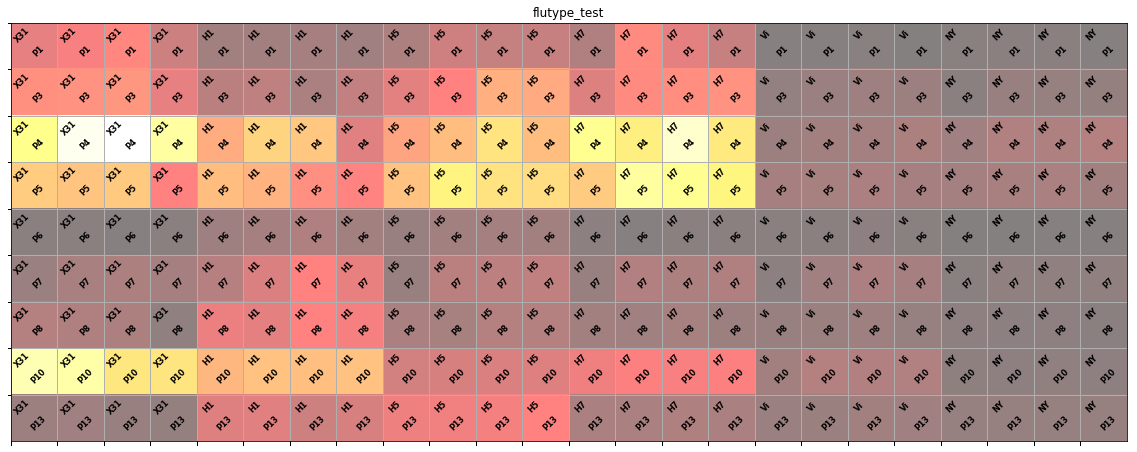

In [111]:
fig, ax = plt.subplots(figsize=(20,13))

#imshow portion
ax.imshow(Spot.pivot(index='Column', columns='Row', values='Intensity'), interpolation='nearest',cmap="hot",alpha=0.5)
#plt.pcolor(Spot["Intensity"].unstack())
#text portion
x, y = np.meshgrid(vir_cor.index.values-1,vir_cor.columns.values-1)
for index in Spot.index:
    #print(y_val)
    ax.text(Spot["Row"].loc[index]-0.90, Spot["Column"].loc[index]-0.90, Spot["Peptide"].loc[index], va='center', ha='center',fontsize=8,weight="bold",rotation=45)
    ax.text(Spot["Row"].loc[index]-1.25, Spot["Column"].loc[index]-1.25, Spot["Virus"].loc[index], va='center', ha='center',fontsize=8,weight="bold",rotation=45)

#set tick marks for grid
ax.set_xticks(Spot["Row"].values-1.5)
ax.set_yticks(Spot["Column"].values-1.5)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(x.min()-0.5, x.max()+0.5)
ax.set_ylim(y.max()+0.5, y.min()-0.5)
ax.grid()
plt.title(data_id,fontsize="large")
fig.savefig("./results/{}_heatmap2.png".format(data_id),bbox_inches='tight')

plt.show()


## Comapct version of heatmap

/home/janekg89/Envs/flutype-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


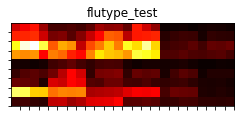

In [112]:
#heatmap of microwellplate
# legend (color bar)

data = output.convert_objects(convert_numeric=True)
fig = plt.figure(figsize=(4.0,2))
plt.imshow(data.T,cmap='hot')
plt.xticks(np.arange(0.5, len(data.index), 1), [],rotation=90)
plt.yticks(np.arange(0.5, len(data.columns), 1), [])
plt.title(data_id,fontsize="large")
fig.savefig("./results/{}_heatmap.png".format(data_id),bbox_inches='tight')

plt.show()


## Errorbar plots of aligned for peptides


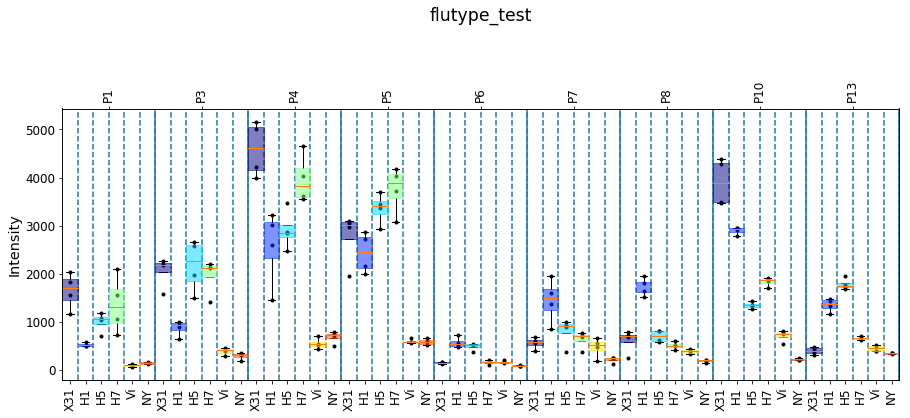

In [113]:
# overview plot of peptide-virus signal
fig = plt.figure(figsize=(15,5.0))
ax2 = plt.subplot(111)
ax = ax2.twiny()

# for x-axis ticks and labels
peptide_ticks_x_axis = []
peptide_label_x_axis = []

virus_ticks_x_axis = []
virus_label_x_axis = []

cmap  = plt.get_cmap('jet')
Nvirus = len(Spot["Virus"].unique())
Npeptides = len(Spot["Peptide"].unique())
spacing = 1.0/Nvirus

for index_peptide, peptide in enumerate(Spot["Peptide"].unique()):
    for index_virus, virus in enumerate(Spot["Virus"].unique()):
        plt.axvline(x=[index_peptide + index_virus * spacing + spacing * 0.5 ], linestyle='dashed')
        # add x-tick position and label for virus
        virus_ticks_x_axis.append(index_peptide + index_virus * spacing)
        virus_label_x_axis.append(virus)
        data=Spot.loc[(Spot['Peptide'] == peptide) & (Spot["Virus"] == virus)]["Intensity"]
        ax.scatter(index_peptide  * np.ones(data.shape) + index_virus * spacing, data, s=500/(Nvirus*Npeptides), color='k', marker='o')
        
        if len(data) > 1: 
            bp = ax.boxplot(data.values, positions=[index_peptide+index_virus*spacing], 
                            patch_artist=True, showfliers=False,widths=spacing)
            plt.setp(bp['boxes'], color=cmap(index_virus*1.0 / Nvirus), alpha=0.5)
            
    # add x-tick position and label for peptide    
    peptide_ticks_x_axis.append(index_peptide + 0.5 - spacing * 0.5)
    peptide_label_x_axis.append(peptide)
    #draw vertical line to seperate peptides
    plt.axvline(x=index_peptide + 1 - spacing * 0.5 )

# setup upper x-axis            
#plt.xticks(peptide_ticks_x_axis,["peptide " + str(s) for s in output.columns],fontsize="large")
#attantion not allways right !!!!!!!! otherwise take upper todo make general
plt.xticks(peptide_ticks_x_axis,peptide_label_x_axis,fontsize="large",rotation=90)
ax.set_xlim(-0.5*spacing , index_peptide + 1 - spacing * 0.5 )

# setup lower x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(virus_ticks_x_axis)
#["peptide " + str(s) for s in output.columns]
ax2.set_xticklabels(virus_label_x_axis,rotation=90,fontsize="large")
ax2.tick_params(labelsize="large") 

ax2.set_ylabel("Intensity",fontsize="x-large")
# nicer plot
ax.set_title(data_id,y=1.30,fontsize="xx-large")
#fig.savefig("./results/{}_barplot.png".format(data_id),bbox_inches='tight')

plt.show()
        


## Errorbar plots of aligned for viruses

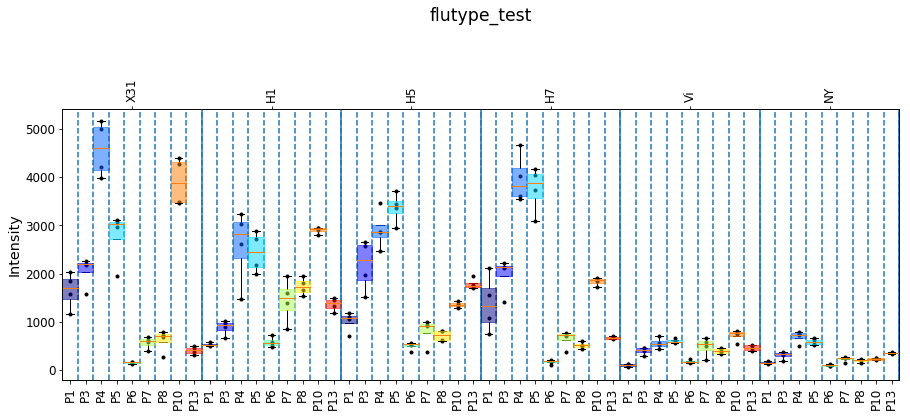

In [114]:
# overview plot of peptide-virus signal
fig = plt.figure(figsize=(15,5.0))
ax2 = plt.subplot(111)
ax = ax2.twiny()

# for x-axis ticks and labels
peptide_ticks_x_axis = []
peptide_label_x_axis = []

virus_ticks_x_axis = []
virus_label_x_axis = []

cmap  = plt.get_cmap('jet')
Nvirus = len(Spot["Virus"].unique())
Npeptides = len(Spot["Peptide"].unique())
spacing = 1.0/Npeptides
for index_virus, virus in enumerate(Spot["Virus"].unique()):
    for index_peptide, peptide in enumerate(Spot["Peptide"].unique()):
        plt.axvline(x=[index_virus + index_peptide * spacing + spacing * 0.5 ], linestyle='dashed')
        # add x-tick position and label for virus
        peptide_ticks_x_axis.append(index_virus + index_peptide * spacing)
        peptide_label_x_axis.append(peptide)
        data=Spot.loc[(Spot['Peptide'] == peptide) & (Spot["Virus"] == virus)]["Intensity"]
        ax.scatter(index_virus  * np.ones(data.shape) + index_peptide * spacing, data, s=500/(Nvirus*Npeptides), color='k', marker='o')
        
        if len(data) > 1: 
            bp = ax.boxplot(data.values, positions=[index_virus+index_peptide*spacing], 
                            patch_artist=True, showfliers=False,widths=spacing)
            plt.setp(bp['boxes'], color=cmap(index_peptide*1.0 / Npeptides), alpha=0.5)
            
    # add x-tick position and label for peptide    
    virus_ticks_x_axis.append(index_virus+ 0.5 - spacing * 0.5)
    virus_label_x_axis.append(virus)
    #draw vertical line to seperate peptides
    plt.axvline(x=index_virus + 1 - spacing * 0.5 )

# setup upper x-axis            
#plt.xticks(peptide_ticks_x_axis,["peptide " + str(s) for s in output.columns],fontsize="large")
#attantion not allways right !!!!!!!! otherwise take upper todo make general
plt.xticks(virus_ticks_x_axis,virus_label_x_axis,fontsize="large",rotation=90)
ax.set_xlim(-0.5*spacing, index_virus + 1 - spacing * 0.5 )

# setup lower x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(peptide_ticks_x_axis)
#["peptide " + str(s) for s in output.columns]
ax2.set_xticklabels(peptide_label_x_axis,rotation=90,fontsize="large")
ax2.tick_params(labelsize="large") 

ax2.set_ylabel("Intensity",fontsize="x-large")
# nicer plot
ax.set_title(data_id,y=1.30,fontsize="xx-large")
#fig.savefig("./results/{}_barplot.png".format(data_id),bbox_inches='tight')

plt.show()

## PCA and reduction to 2 dimentions & plot

In [115]:
def map_strings_to_number(strings):
    """Transforms list of strings into numbers."""
    counter = 1
    d = {}
    numbers = []
    for s in strings:
        if s in d:
            pass
        else:
            d[s] = counter
            counter+=1
        numbers.append(d[s])
    return numbers
    
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    # Note that if base_cmap is a String or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for String, None, or a colormap instance:
    if N == 1:
        base = plt.cm.get_cmap(base_cmap)
        color_list = base(np.linspace(0, 1, N+1))
        cmap_name = base.name + str(N)
        
    else:
    
        base = plt.cm.get_cmap(base_cmap)
        color_list = base(np.linspace(0, 1, N))
        cmap_name = base.name + str(N)
        
    return base.from_list(cmap_name, color_list, N)


In [116]:
#reshapeing data for pca
Spots_PCA = Spot[["Peptide","Virus","Intensity","Replica"]]
Spots_Pre_PCA = Spots_PCA.set_index(["Virus","Peptide","Replica"])
Spots_PCA = Spots_Pre_PCA.pivot_table(index=["Virus","Replica"],columns="Peptide",values="Intensity")
# here a different method could be better. e.g. mean ...
Spots_PCA_complete = Spots_PCA.dropna()
#---------------------------------------#
# maybe an algorithm for selcting only 
# good peptides is reasonable
display(Spots_PCA_complete)

Peptide          P1   P10   P13    P3    P4    P5   P6    P7    P8
Virus Replica                                                     
H1    0         510  2791  1445   892  2609  2874  484   849  1650
      1         524  2950  1482   971  3227  2727  573  1384  1527
      2         580  2907  1174   657  3020  2175  732  1951  1947
      3         504  2952  1325  1007  1469  1993  521  1598  1802
H5    0         702  1279  1697  1504  2476  2942  374   379   627
      1        1187  1328  1736  1974  2864  3707  521   903   590
      2        1052  1363  1760  2658  3470  3450  547   937   805
      3        1092  1435  1947  2577  2854  3359  534   995   816
H7    0         734  1712   633  1410  4035  3086  205   370   519
      1        2108  1891   663  2117  3621  4178  108   769   501
      2        1559  1844   707  2139  4662  4044  179   700   604
      3        1072  1914   656  2214  3552  3731  171   730   427
NY    0         143   235   348   182   500   545   86   135   213
      1         177   216   363   367   746   616   79   260   201
      2         157   253   330   338   713   660  117   252   217
      3         122   207   358   309   785   523   96   249   150
Vi    0          87   541   399   286   436   567  164   194   368
      1         111   806   408   393   516   591  167   491   424
      2         129   766   514   462   555   669  217   667   450
      3          67   746   503   443   702   581  144   570   332
X31   0        1569  4396   443  2185  3988  3104  161   394   788
      1        1840  4284   486  2203  5003  2975  148   613   726
      2        2039  3493   372  2269  5163  3067  126   689   692
      3        1168  3472   314  1578  4211  1948  172   568   258

In [117]:
if len(Spots_PCA_complete.columns) > 1 and len(Spots_PCA_complete.index) > 1 :
    #build model
    pca = decomposition.PCA()
    pca.fit(Spots_PCA_complete)
    #perform pca
    pca_score = pca.explained_variance_ratio_ 
    pca_components = pca.components_
    x_train_pca = pca.transform(Spots_PCA_complete)

    output_pca = pd.DataFrame(x_train_pca, index = Spots_PCA_complete.index)
    # store color information
    output_pca.insert(0, "color", map_strings_to_number(Spots_PCA_complete.index.droplevel(1)))
    #output_pca.insert(1, "virus", output.index)


    print("PCA score for principal components (explained variance):\n", pca_score.round(3))
    corr_values = dict(zip(Spots_PCA_complete.columns, pca_components[0]))
    feature_max_cor = max(corr_values, key=corr_values.get)
    print("Feature with max. Variation:",feature_max_cor )
    print("PCA Components in feature space:", pca_components[0])


    cor_to_strongest_feature = Spots_PCA_complete[Spots_PCA_complete.columns[:]].corr()[feature_max_cor][:]
    print("\nThe Correlation of the Features to the Feature with highest Varaiance")
    print(cor_to_strongest_feature)
elif len(Spots_PCA_complete.columns) < 2:
    Print("You have selected measuraments with less than two peptides. No PCA is possible ")
elif len(Spots_PCA_complete.index) < 2:
    Print("You have selected measuraments with less than two two viruses (also replica) with complete set. No PCA is possible ")


('PCA score for principal components (explained variance):\n', array([ 0.754,  0.119,  0.085,  0.018,  0.011,  0.009,  0.003,  0.002,  0.   ]))
('Feature with max. Variation:', 'P4')
('PCA Components in feature space:', array([ 0.2419204 ,  0.43061312,  0.07229833,  0.3079076 ,  0.63758704,
        0.48778138,  0.02177407,  0.07039287,  0.07832974]))

The Correlation of the Features to the Feature with highest Varaiance
Peptide
P1     0.887674
P10    0.772283
P13    0.181258
P3     0.838442
P4     1.000000
P5     0.849343
P6     0.149624
P7     0.276062
P8     0.250445
Name: P4, dtype: float64


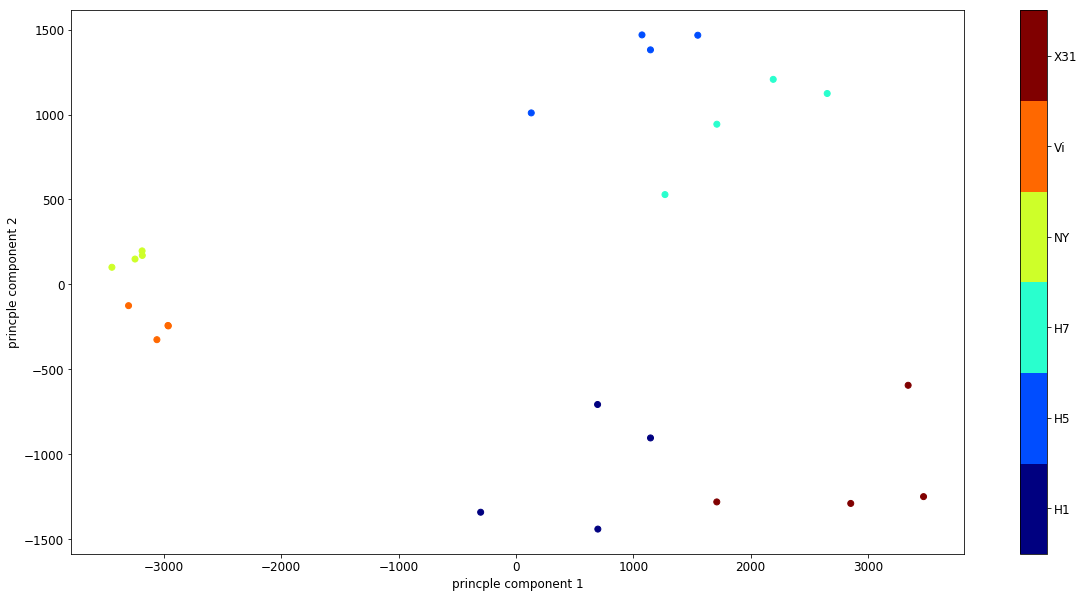

In [118]:
fig = plt.figure(figsize=(20, 10))
plt.xlabel("princple component 1",  size='large')
plt.ylabel("princple component 2",  size='large')
plt.tick_params(labelsize="large") 
plt.scatter(output_pca[0], output_pca[1], 
            c=output_pca["color"].values, cmap=discrete_cmap(output_pca["color"].values.max(), 'jet'))


color_mapping = output_pca[['color']].sort_values(by=["color"])

cbar = plt.colorbar(ticks=sorted(output_pca["color"].unique()))
cbar.set_ticklabels(color_mapping.index.droplevel(1).unique())
cbar.ax.tick_params(labelsize="large") 
plt.clim(0.5, output_pca["color"].values.max() + 0.5)

plt.show()

## Correlation analysis

In [119]:
from matplotlib.collections import EllipseCollection

def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90,fontsize="xx-large")
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index,fontsize="xx-large")

    return ec

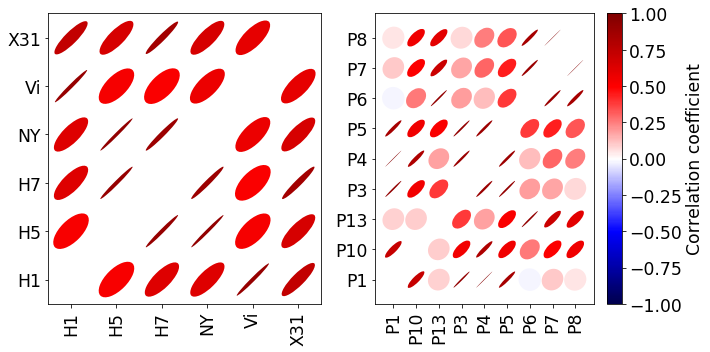

In [120]:
unique_virus_peptide = Spots_Pre_PCA.pivot_table(index="Virus",columns="Peptide",values="Intensity")
x = 2
if unique_virus_peptide.shape[0] < x or unique_virus_peptide.shape[1] < x:
    print("{}: Number of unique viruses".format(unique_virus_peptide.shape[0]))
    print("{}: Number of unique peptides".format(unique_virus_peptide.shape[1]))
    print("-> Not enough unique viruses or peptides in data set")
    
else:
    data = unique_virus_peptide.T.corr()
    f, (ax, ax2) = plt.subplots(1, 2,figsize=(10,5.0))
    m = plot_corr_ellipses(data, ax=ax, cmap='seismic',clim=[-1, 1])

    ax.margins(0.1)

    m = plot_corr_ellipses(unique_virus_peptide.corr(), ax=ax2, cmap='seismic',clim=[-1, 1])
    cb = f.colorbar(m)
    cb.ax.tick_params(labelsize="xx-large") 

    cb.set_label('Correlation coefficient',fontsize="xx-large")
    ax2.margins(0.1)
    f.tight_layout()

    f.savefig("./results/{}_corr_matrix_plot.png".format(data_id),bbox_inches='tight')

    plt.show()